# Analytical approach

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import egttools as egt

In [2]:
# Parameters for the pay-off matrix
## The reward values
R = 1
S = -1
T = 2
P = 0
## The values used to calculate the reward for a certain strategy
r = 50
theta = 0.3 # trust threshold
p = 0.25 # Chance of checking
epsilon = 0.25 # opportunity cost
gamma = 1 # Importance of the game
# Parameters for the game settings
nb_strategies_with = 5
strategies = ["ALLC","ALLD","TFT","TUC","TUD"]
nb_strategies_without = 3
beta = 0.1 # intensity of selection
Z = 100 # Population size

In [3]:
def calculate_pay_off(R,S,T,P,r,theta,p,epsilon,gamma):
    R *= gamma
    S *= gamma
    T *= gamma
    P *= gamma
    # static table
    ## Always cooperate (ALLC)
    ALLC_ALLC = R
    ALLC_ALLD = S
    ALLC_TFT = R
    ALLC_TUC = R
    ALLC_TUD = (theta*R+(r-theta)*S)/r
    ALLC = [ALLC_ALLC,ALLC_ALLD,ALLC_TFT,ALLC_TUC,ALLC_TUD]
    ## Always defect (ALLD)
    ALLD_ALLC = T
    ALLD_ALLD = P
    ALLD_TFT = (T+(r-1)*P)/r
    ALLD_TUC = (T+(r-1)*P)/r
    ALLD_TUD = (T+(r-1)*P)/r
    ALLD = [ALLD_ALLC,ALLD_ALLD,ALLD_TFT,ALLD_TUC,ALLD_TUD]
    ## Tit for Tat (TFT)
    TFT_ALLC = R-epsilon
    TFT_ALLD = (S+(r-1)*P)/r - epsilon
    TFT_TFT = R - epsilon
    TFT_TUD = R - epsilon
    TFT_TUC = (theta*R+S+(r-theta-1)*P)/r - epsilon
    TFT = [TFT_ALLC,TFT_ALLD,TFT_TFT,TFT_TUD,TFT_TUC]
    ## Trust-based Cooperate (TUC)
    TUC_ALLC = R - (theta*epsilon)/r - (p*(r-theta)*epsilon)/r
    TUC_ALLD = (S + (r-1)*P)/r - epsilon
    TUC_TFT = R-(theta*epsilon)/r-(p*(r-theta)*epsilon)/r
    TUC_TUC = R-(theta*epsilon)/r-(p*(r-theta)*epsilon)/r
    TUC_TUD = (theta*R-theta*epsilon)/r + 1/r*((S*(1-(1-p)**(r-theta)))/p + ((P-epsilon)*((1-p)**(r-theta)+(r-theta)*p - 1))/p)
    TUC = [TUC_ALLC,TUC_ALLD,TUC_TFT,TUC_TUC,TUC_TUD]
    ## Trust-based Defect (TUD)
    TUD_ALLC = (epsilon*R+(r-epsilon)*T-theta*epsilon)/r
    TUD_ALLD = (S+(r-1)*P)/r-epsilon
    TUD_TFT = (theta*R+T+(r-theta-1)*P-theta*epsilon)/r
    TUD_TUC = (theta*R-theta*epsilon)/r + 1/r*((T*(1 - (1 - p) ** (r - theta)))/p + (P*((1-p)**(r-theta) + (r - theta)*p - 1))/p)
    TUD_TUD = (theta*R+(r - theta) * P - theta*epsilon)/r
    TUD = [TUD_ALLC,TUD_ALLD,TUD_TFT,TUD_TUC,TUD_TUD]
    return np.array([
        ALLC,
        ALLD,
        TFT,
        TUC,
        TUD,])

In [4]:
pay_off = calculate_pay_off(R,S,T,P,r,theta,p,epsilon,gamma)
evolver = egt.analytical.StochDynamics(nb_strategies_with, pay_off, Z)
evolver.mu = 0
stationary_SML = evolver.calculate_stationary_distribution(beta)

In [5]:
print("time spent as Always Cooperate: {} & time spent as Always Cheat: {} & time spent as Tit for Tat: {} & time spent as Trust-based Cooperate {} & time spent as Trust-based Defect {}".format(*stationary_SML))

time spent as Always Cooperate: 0.043380057204576994 & time spent as Always Cheat: 0.2660268028094428 & time spent as Tit for Tat: 0.11762058717985252 & time spent as Trust-based Cooperate 0.418067599937874 & time spent as Trust-based Defect 0.1549049528682536


<BarContainer object of 5 artists>

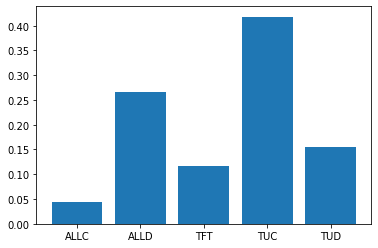

In [6]:
fig,ax = plt.subplots()
ax.bar(["ALLC","ALLD","TFT","TUC","TUD"],[*stationary_SML])

## Influence of $\epsilon$

In [7]:
def test_epsilons(R,S,T,P,r,theta,p,gamma,nb_strategies_with,strategies,nb_strategies_without,beta,Z):
    epsilons = np.arange(0,1.1,0.1)
    # for the frequencies of strategies
    fig_strat,ax_strat = plt.subplots()
    results_with = np.zeros((nb_strategies_with,len(epsilons)))
    # for the frequency of cooperation
    fig_coop,ax_coop = plt.subplots()
    results_without = np.zeros((nb_strategies_without,len(epsilons)))
    for pos in range(len(epsilons)):
        # for all strategies
        epsilon = epsilons[pos]
        pay_off = calculate_pay_off(R,S,T,P,r,theta,p,epsilon,gamma)
        evolver = egt.analytical.StochDynamics(nb_strategies_with, pay_off, Z)
        evolver.mu = 0
        stationary_SML = evolver.calculate_stationary_distribution(beta)
        for strategy,v in zip(range(nb_strategies_with),stationary_SML):
            results_with[strategy][pos] = v
        # for all strategies except TUC and TUD
        evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z)
        evolver.mu = 0
        stationary_SML = evolver.calculate_stationary_distribution(beta)
        for strategy,v in zip(range(nb_strategies_without),stationary_SML):
            results_without[strategy][pos] = v
    # for the frequencies of strategies
    for pos in range(nb_strategies_with):
        ax_strat.plot(epsilons,results_with[pos],label = strategies[pos])
    ax_strat.legend()
    ax_strat.set_xlabel("Opportunity cost $\epsilon$")
    ax_strat.set_ylabel("Frequency")
    ax_strat.set_xlim(0,1)
    ax_strat.set_ylim(0,1)
    ax_strat.set_title("Influence of $\epsilon$ on frequency of strategies")
    # for the frequency of cooperation
    without_trust = np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(epsilons))])
    with_trust = np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] for pos in range(len(epsilons))])
    ax_coop.plot(epsilons,without_trust,label = "without TUC/TUD")
    ax_coop.plot(epsilons,with_trust,label = "with TUC/TUD")
    ax_coop.fill_between(epsilons, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
    ax_coop.fill_between(epsilons, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)

    ax_coop.legend()
    ax_coop.set_xlim(0,1)
    ax_coop.set_ylim(0,1)
    ax_coop.set_xlabel("Opportunity cost $\epsilon$")
    ax_coop.set_ylabel("Frequency")
    ax_coop.set_title("Influence of $\epsilon$ on frequency of cooperation")

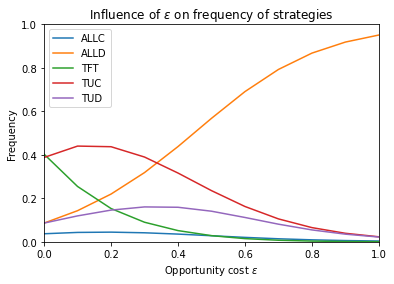

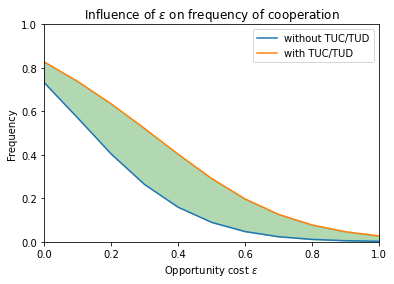

In [8]:
test_epsilons(R,S,T,P,r,theta,p,gamma,nb_strategies_with,strategies,nb_strategies_without,beta,Z)

## Influence of $\gamma$ and r

In [9]:
def test_gamma_r(R,S,T,P,theta,p,epsilon,nb_strategies_with,strategies,nb_strategies_without,beta,Z):
    gammas = np.geomspace(0.1,1000,100)
    rs = np.array([20,50,100])
    for r in rs:
        # for the frequencies of strategies
        fig_strat,ax_strat = plt.subplots()
        results_with = np.zeros((nb_strategies_with,len(gammas)))
        # for the frequency of cooperation
        fig_coop,ax_coop = plt.subplots()
        results_without = np.zeros((nb_strategies_without,len(gammas)))
        for pos in range(len(gammas)):
            # for all strategies
            gamma = gammas[pos]
            pay_off = calculate_pay_off(R,S,T,P,r,theta,p,epsilon,gamma)
            evolver = egt.analytical.StochDynamics(nb_strategies_with, pay_off, Z)
            evolver.mu = 0
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            for strategy,v in zip(range(nb_strategies_with),stationary_SML):
                results_with[strategy][pos] = v
            # for all strategies except TUC and TUD
            evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z)
            evolver.mu = 0
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            for strategy,v in zip(range(nb_strategies_without),stationary_SML):
                results_without[strategy][pos] = v
        # for the frequencies of strategies
        for pos in range(nb_strategies_with):
            ax_strat.plot(gammas,results_with[pos],label = strategies[pos])
        ax_strat.legend()
        ax_strat.set_xlabel("importance of the game $\gamma$")
        ax_strat.set_ylabel("Frequency")
        ax_strat.set_xlim(0.1,1000)
        ax_strat.set_xscale("symlog")
        ax_strat.set_ylim(0,1)
        ax_strat.set_title(f"Influence of r = {r} and $\gamma$  on frequency of strategies")
        # for the frequency of cooperation
        without_trust = np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(gammas))])
        with_trust = np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] for pos in range(len(gammas))])
        ax_coop.plot(gammas,without_trust,label = "without TUC/TUD")
        ax_coop.plot(gammas,with_trust,label = "with TUC/TUD")
        ax_coop.fill_between(gammas, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
        ax_coop.fill_between(gammas, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)

        ax_coop.legend()
        ax_coop.set_xscale("symlog")
        ax_coop.set_xlim(0.1,1000)
        ax_coop.set_ylim(0,1)
        ax_strat.set_xlabel("importance of the game $\gamma$")
        ax_coop.set_ylabel("Frequency")
        ax_strat.set_title(f"Influence of r = {r} and $\gamma$  on frequency of cooperation")

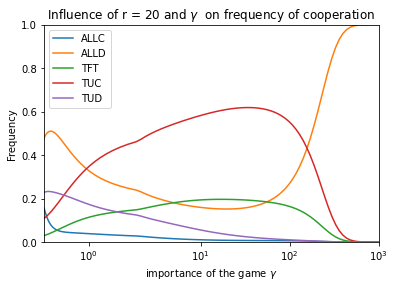

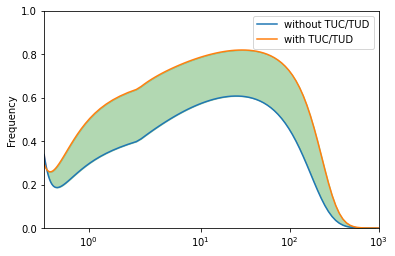

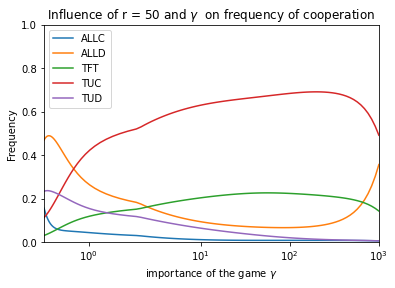

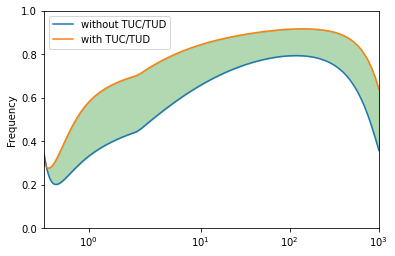

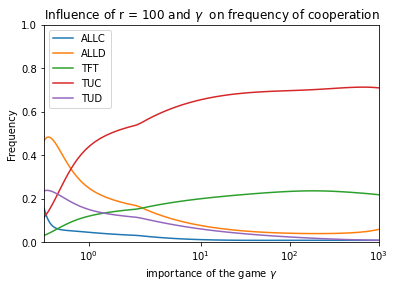

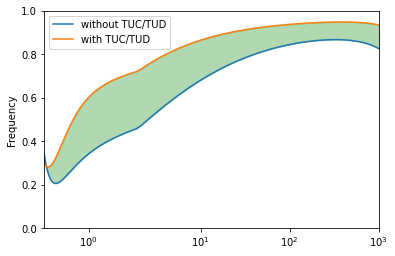

In [10]:
test_gamma_r(R,S,T,P,theta,p,epsilon,nb_strategies_with,strategies,nb_strategies_without,beta,Z)

## Influence of p and $\epsilon$

In [17]:
def test_p_epsilon(R,S,T,P,r,theta,gamma,nb_strategies_with,strategies,nb_strategies_without,beta,Z):
    ps = np.arange(1,101,1)
    epsilons = np.array([0,0.2,0.5])
    for epsilon in epsilons:
        # for the frequencies of strategies
        fig_strat,ax_strat = plt.subplots()
        results_with = np.zeros((nb_strategies_with,len(ps)))
        # for the frequency of cooperation
        fig_coop,ax_coop = plt.subplots()
        results_without = np.zeros((nb_strategies_without,len(ps)))
        for pos in range(len(ps)):
            # for all strategies
            p = 1/ps[pos]
            pay_off = calculate_pay_off(R,S,T,P,r,theta,p,epsilon,gamma)
            evolver = egt.analytical.StochDynamics(nb_strategies_with, pay_off, Z)
            evolver.mu = 0
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            for strategy,v in zip(range(nb_strategies_with),stationary_SML):
                results_with[strategy][pos] = v
            # for all strategies except TUC and TUD
            evolver = egt.analytical.StochDynamics(nb_strategies_without, pay_off, Z)
            evolver.mu = 0
            stationary_SML = evolver.calculate_stationary_distribution(beta)
            for strategy,v in zip(range(nb_strategies_without),stationary_SML):
                results_without[strategy][pos] = v
        # for the frequencies of strategies
        for pos in range(nb_strategies_with):
            ax_strat.plot(ps,results_with[pos],label = strategies[pos])
        ax_strat.legend()
        ax_strat.set_xlabel("trustfulness $1/p$")
        ax_strat.set_ylabel("Frequency")
        ax_strat.set_xlim(0,100)
        ax_strat.set_ylim(0,1)
        ax_strat.set_title(f"Influence of $\epsilon$ = {epsilon} and $p$  on frequency of strategies")
        # for the frequency of cooperation
        without_trust = np.array([results_without[0][pos] + results_without[2][pos] for pos in range(len(ps))])
        with_trust = np.array([results_with[0][pos] + results_with[2][pos] + results_with[3][pos] for pos in range(len(ps))])
        ax_coop.plot(ps,without_trust,label = "without TUC/TUD")
        ax_coop.plot(ps,with_trust,label = "with TUC/TUD")
        ax_coop.fill_between(ps, with_trust, without_trust, where=(with_trust > without_trust), color='green', alpha=0.3)
        ax_coop.fill_between(ps, with_trust, without_trust, where=(with_trust < without_trust), color='red', alpha=0.3)

        ax_coop.legend()
        ax_coop.set_xlim(0,100)
        ax_coop.set_ylim(0,1)
        ax_strat.set_xlabel("trustfulness $1/p$")
        ax_coop.set_ylabel("Frequency")
        ax_strat.set_title(f"Influence of $\epsilon$ = {epsilon} and $p$  on frequency of cooperation")

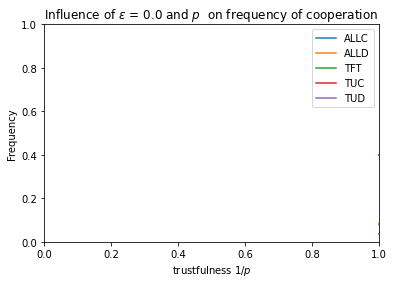

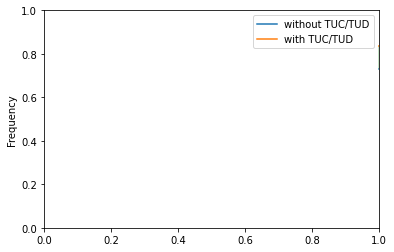

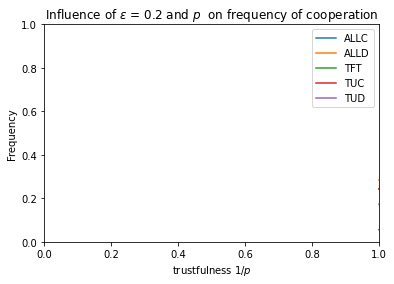

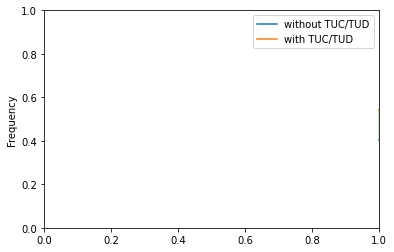

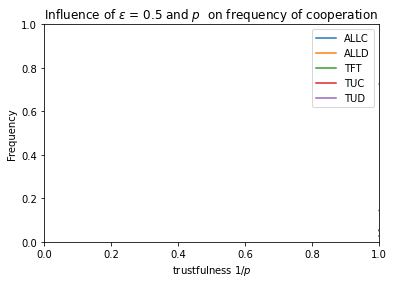

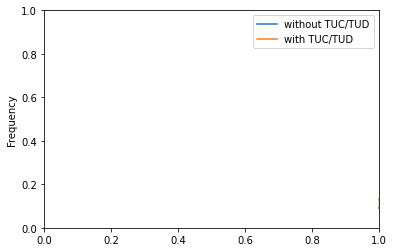

In [18]:
test_p_epsilon(R,S,T,P,r,theta,gamma,nb_strategies_with,strategies,nb_strategies_without,beta,Z)